In [1]:
# Q11. MTK ver
# modules
using ModelingToolkit
using DifferentialEquations
using Plots
using ModelingToolkit: t_nounits as t, D_nounits as D, @variables, @parameters, @named, @unpack, @mtkbuild
using Symbolics
using BenchmarkTools

# HX_PHX struct
struct Wall
    rho::Float64
    V::Float64
    m::Float64
    Cp::Float64
    m_elem::Float64
end
struct Ref
    V::Float64
    A_cs::Float64
    V_elem::Float64
    A_elem::Float64
    Ge1::Float64
    Ge2::Float64
end
struct Fld
    V::Float64
    A_cs::Float64
    V_elem::Float64
    A_elem::Float64
    k::Float64
    Pr::Float64
    rho::Float64
    mu::Float64
    Cp::Float64
    mdot::Float64
    T_in::Float64
end
struct HX_PHX
    N_t::Int64
    N_c::Int64
    N_f::Int64
    L_w::Float64
    L_v::Float64
    A_t::Float64
    phi::Float64
    p::Float64
    t::Float64
    b::Float64
    D_h::Float64
    beta::Float64
    N_CV::Int64
    Wall::Wall
    Ref::Ref
    Fld::Fld
    isCounterFlow::Bool
end
# make_HX ftn
function make_HX(N_t::Int64, L_w::Float64, L_v::Float64, A_t::Float64, p::Float64, t::Float64, N_CV::Int64, isCounterFlow::Bool)
    # DIC-193-33 PHX. http://www.dibr.co.kr/exchanger/detail/D93RP00056?ts=1735978818&capacity=0.5&cate=162&
    N_t = N_t
    N_c = (N_t - 1) / 2
    N_f = (N_t - 1) / 2
    L_w = L_w
    L_v = L_v
    A_t = A_t
    ϕ = A_t / (L_w * L_v * (N_t - 2))
    p = p
    t = t
    b = p - t
    D_h = 2 * b / ϕ
    β = 25 * pi / 180
    N_CV = N_CV

    # Wall Geo, Props
    Wall_rho = 7.93e3 # STS 304 density
    Wall_V = A_t * t
    Wall_m = Wall_V * Wall_rho
    Wall_Cp = 502 # specific heat

    # Ref, Fld Geo
    Ref_V = N_c * L_w * b* L_v
    Ref_A_cs = N_c * L_w * b
    Fld_V =  N_f * L_w * b * L_v
    Fld_A_cs = N_f * L_w * b

    # Geo per Element
    Wall_m_elem = Wall_m / N_CV
    Ref_V_elem = Ref_V / N_CV
    Ref_A_elem = A_t / N_CV
    Fld_V_elem = Fld_V / N_CV
    Fld_A_elem = Ref_A_elem

    # Ref UA Props
    Ref_Ge1 = 11.22*(b/D_h)^(-2.83) * (pi/2 - β)^(-4.5)
    Ref_Ge2 = 0.35*(b/D_h)^(0.23) * (pi/2 - β)^(1.48)

    # Fld Props (Water, 15C, Saturated Liquid, refprop)
    Fld_k = 0.5887
    Fld_Pr = 1.7058
    Fld_rho = 999.0561
    Fld_mu = 0.0011
    Fld_Cp = 4.1888e3

    # Fld
    Fld_mdot = 0.1
    Fld_T_in = 273.15 + 40
    isCounterFlow = isCounterFlow

    HX_Wall = Wall(Wall_rho, Wall_V, Wall_m, Wall_Cp, Wall_m_elem)
    HX_Ref = Ref(Ref_V, Ref_A_cs, Ref_V_elem, Ref_A_elem, Ref_Ge1, Ref_Ge2)
    HX_Fld = Fld(Fld_V, Fld_A_cs, Fld_V_elem, Fld_A_elem, Fld_k, Fld_Pr, Fld_rho, Fld_mu, Fld_Cp, Fld_mdot, Fld_T_in)
    return HX_PHX(N_t, N_c, N_f, L_w, L_v, A_t, ϕ, p, t, b, D_h, β, N_CV, HX_Wall, HX_Ref, HX_Fld, isCounterFlow)
end

make_HX (generic function with 1 method)

In [2]:
# HX_C
HX_C_N_t = 33
HX_C_L_w = 0.083
HX_C_L_v = 0.154
HX_C_A_t = 0.434
HX_C_p = 2.35e-3
HX_C_t = 0.4e-3
HX_C_N_CV = 5
HX_C_isCounterFlow = true
HX_C = make_HX(HX_C_N_t, HX_C_L_w, HX_C_L_v, HX_C_A_t, HX_C_p, HX_C_t, HX_C_N_CV, HX_C_isCounterFlow)

HX_PHX(33, 16, 16, 0.083, 0.154, 0.434, 1.095290251916758, 0.00235, 0.0004, 0.0019500000000000001, 0.0035607, 0.4363323129985824, 5, Wall(7930.0, 0.00017360000000000002, 1.376648, 502.0, 0.2753296), Ref(0.0003987984000000001, 0.0025896000000000005, 7.975968000000001e-5, 0.0868, 34.95278503589673, 0.3672934117781399), Fld(0.0003987984000000001, 0.0025896000000000005, 7.975968000000001e-5, 0.0868, 0.5887, 1.7058, 999.0561, 0.0011, 4188.8, 0.1, 313.15), true)

In [22]:
# CoolProp
import CoolProp as CP
# CoolProp with MTK (Tabular / Consider to change into PINN)

const handle = CP.AbstractState_factory("HEOS&BICUBIC", "R410A")

0

In [23]:
# ρ, T from P, h
function _R410a_ρ(P::Float64, h::Float64, handle = handle)
    CP.AbstractState_update(handle, CP.get_input_pair_index("HmassP_INPUTS"), h, P)   
    return CP.AbstractState_keyed_output(handle, CP.get_param_index("Dmass"))
end
function _R410a_T(P, h, handle=handle)
    CP.AbstractState_update(handle, CP.get_input_pair_index("HmassP_INPUTS"), h, P)   
    return CP.AbstractState_keyed_output(handle, CP.get_param_index("T"))
end
function _R410a_L(P, handle=handle)
    CP.AbstractState_update(handle, CP.get_input_pair_index("PQ_INPUTS"), P, 0)
    return CP.AbstractState_keyed_output(handle, CP.get_param_index("Hmass")), 
    CP.AbstractState_keyed_output(handle, CP.get_param_index("Dmass")), 
    CP.AbstractState_keyed_output(handle, CP.get_param_index("L")),
    CP.AbstractState_keyed_output(handle, CP.get_param_index("V")),
    CP.AbstractState_keyed_output(handle, CP.get_param_index("Prandtl"))
end
function _R410a_V(P, handle=handle)
    CP.AbstractState_update(handle, CP.get_input_pair_index("PQ_INPUTS"), P, 1)
    return CP.AbstractState_keyed_output(handle, CP.get_param_index("Hmass")),
    CP.AbstractState_keyed_output(handle, CP.get_param_index("Dmass"))
end
# dP == 1, dh == 1 for calc der
function _R410a_dρdP_h(P,h, handle=handle) 
    return _R410a_ρ(P+1, h) - _R410a_ρ(P,h)
end
function _R410a_dρdh_P(P,h, handle=handle)
    return _R410a_ρ(P, h+1) - _R410a_ρ(P,h)
end

R410a_ρ(P, h) =_R410a_ρ(P,h)
R410a_T(P,h) = _R410a_T(P,h)
R410a_L(P) = _R410a_L(P)
R410a_V(P) = _R410a_V(P)
R410a_dρdP_h(P,h) = _R410a_dρdP_h(P,h)
R410a_dρdh_P(P,h) = _R410a_dρdh_P(P,h)

# Symbolics
@register_symbolic R410a_ρ(P, h) 
@register_symbolic R410a_T(P, h)
@register_symbolic R410a_dρdP_h(P,h)
@register_symbolic R410a_dρdh_P(P,h)


# Helper ftns
# 1. regPow
# (Qiao et al. 2022), regPow_gen
function regPow(x, a, b, δ)
    return x^b * (x*x + δ*δ)^((a-b) / 2)
end
function regSqrt(x)
    return regPow(x, 0.5, 3, 0.001)
end
# 2. Func for UA_elem
function U_func_full(P::Float64, h::Float64, mdot::Float64, HX::HX_PHX)
    h_L, ρ_L, k_L, mu_L, Pr_L = R410a_L(P)
    h_V, ρ_V = R410a_V(P)
    x = (h - h_L) / (h_V - h_L)

    # Single phase 
    G = mdot / HX.Ref.A_cs
    Re_L = G * HX.D_h / mu_L
    U_ref_single = 0.295 * (k_L/HX.D_h) * ifelse(Re_L >= 0.0, regPow(Re_L, 0.64, 3, 0.1), 0.0) * Pr_L^0.32 * (π/2 - HX.beta)^0.09

    # Two phase
    G_eq_tp = G * (1-x + x*(ρ_L/ρ_V)^0.5)
    Re_eq_tp = G_eq_tp * HX.D_h / mu_L
    U_ref_tp = HX.Ref.Ge1 * (k_L/HX.D_h) * ifelse(Re_eq_tp >= 0.0, regPow(Re_eq_tp, HX.Ref.Ge2, 3, 0.1), 0.0) * Pr_L^(1/3)

    slope1 = (U_ref_tp - U_ref_single) / 0.1
    slope2 = (U_ref_single - U_ref_tp) / 0.1 # slope2 == -slope1

    # Smoothing with ifelse
    U_ref = U_ref_single +
           ifelse(x > 0.0, slope1 * (x - 0.0), 0) +      # x=0, 0 -> slope1
           ifelse(x > 0.1, -slope1 * (x - 0.1), 0) +     # x=0.1, slope1 -> 0
           ifelse(x > 0.9, slope2 * (x - 0.9), 0) +      # x=0.9, 0 -> slope2
           ifelse(x > 1.0, -slope2 * (x - 1.0), 0)       # x=1.0, slope2 -> 0

    return U_ref
end
# 3. Fld UA_elem calc / Const
function U_func_Fld(HX::HX_PHX)
    G = HX.Fld.mdot / HX.Fld.A_cs
    Re_Fld = G * HX.D_h / HX.Fld.mu
    U_ref_Fld = 0.295 * (HX.Fld.k/HX.D_h) * Re_Fld^0.64 * HX.Fld.Pr^0.32 * (π/2 - HX.beta)^0.09
    return U_ref_Fld
end
# 4. Func for h_flow
# Qiao et al. (2015) : Transient modeling of a flash tank vapor injection heat pump system - Part I: Model development
function h_flow_func(P, h)
    h_L, ρ_L, _, _, _ = R410a_L(P)
    h_V, ρ_V = R410a_V(P)
    x = (h - h_L) / (h_V - h_L)
    # Single phase
    if abs(x - 0.5) >= 0.5   
        return h
    end
    ρ = R410a_ρ(P, h)

    # Two phase
    γ = (ρ - ρ_L) / (ρ_V - ρ_L) 
    # Zivi (1964) : c = 1, q = 1, r = (2/3), s = 0
    # c, q, r = 1.0, 1.0, 2/3
    # Smith (1969) : c = 0.79, q = 0.78, r = 0.58, s = 0
    c, q, r = 0.79, 0.78, 0.58
    x_flow = γ^(1/q) / (γ^(1/q) + ((1/c)*(ρ_L / ρ_V)^(r))^(1/q) * (1 - γ)^(1/q) )

    h_flow = h + (x_flow - x) * (h_V - h_L)
    return h_flow
end

# Wrappers
U_func(P, h, mdot) = U_func_full(P, h, mdot, HX_C)
# Symbolics
@register_symbolic regSqrt(x)
@register_symbolic U_func(P, h, mdot)
@register_symbolic h_flow_func(P, h)

# Utils

In [5]:
# 1. Params, Variables for Ref
N = HX_C.N_CV
U_Fld_elem = U_func_Fld(HX_C)

# Init Props
P_in_val = 3200e3
P_out_val = 3000e3
h_in_val = 450e3
c1_val = 9e-6
c2_val = c1_val
Δt_val = 3e-3  #[s]

0.003

In [6]:
# 1. Params for HX
# 1-0. Init cond
@parameters begin
    c1=c1_val 
    c2=c2_val
    P_in=P_in_val
    P_out=P_out_val
    h_init=h_in_val
    Δt = Δt_val  #[s]
end

# 1-1. Ref side
@parameters begin
    HX_Ref_A_elem = HX_C.Ref.A_elem
    HX_Ref_V_elem = HX_C.Ref.V_elem
end
# 1-2. Wall Side
@parameters begin
    HX_Wall_m_elem = HX_C.Wall.m_elem
    HX_Wall_Cp = HX_C.Wall.Cp
end
# 1-3. Fld Side
@parameters begin
    HX_Fld_mdot_in = HX_C.Fld.mdot
    HX_Fld_T_in = HX_C.Fld.T_in
    HX_Fld_A_elem = HX_C.Fld.A_elem
    HX_Fld_Cp = HX_C.Fld.Cp
    UA_Fld_elem = U_Fld_elem * HX_C.Fld.A_elem # UA const for Fld side
end

# 2. Variables for HX
# 2-1. Ref Side
    # Static
@variables begin
    P(t)
    h(t)[1:N]
    UA_elem(t)[1:N]
    UA_elem_hat(t)[1:N]
end
    # Flow
@variables begin
    mdot(t)[1:N+1]
    Q_r(t)[1:N]
end
# 2-2. Wall Side
@variables T_wall(t)[1:N]
# 2-3. Fld Side
    # Static
@variables begin
    T_Fld(t)[1:N+1]
end
    # Flow
@variables begin
    Q_f(t)[1:N]
end

1-element Vector{Symbolics.Arr{Num, 1}}:
 (Q_f(t))[1:5]

In [24]:
# Solvable with QNDF/Rodas5P [reltol = 1e-3] / Implicit form

# 3-1. Cond
# 3-1.1 Cond_Ref_side
# Const P method (no friction)
cond_Ref = [
    [
    # Algebraic eqns for Ref
    #= Flow vars cal(Q_r[i] : By Static vars (P, h[i], ρ[N]), T)
    (Qiao et al., 2018) On Closure Relations for Dynamic Vapor Compression Cycle models
    Low Pass Filtering of UA_elem
    =#
    UA_elem_hat[i] ~ U_func(P, h[i], mdot[i]) * HX_Ref_A_elem,
    D(UA_elem[i]) ~ (UA_elem_hat[i] - UA_elem[i]) / Δt,
    Q_r[i] ~ UA_elem[i] * (T_wall[i] - R410a_T(P, h[i])),
    
    #=Differential eqns for Ref [Static vars diff by flow vars(H_in, H_out, Q_r)]
    (1) Mass conservation
    HX_Ref_V_elem * D(ρ[i]) == mdot_in[i] - mdot_out[i],
    (2) Energy conservation
    HX_Ref_V_elem * (D(ρ[i] * h[i]) - D(P[i])) == H_in[i] - H_out[i] + Q_r[i]
    (3) Partial eqns
    D(ρ[i]) == dρdP_h(P, h[i]) * D(P) + dρdh_P(P, h[i]) * D(h[i])
    =#
    HX_Ref_V_elem * (R410a_dρdP_h(P, h[i]) * D(P) + R410a_dρdh_P(P, h[i]) * D(h[i])) ~ (mdot[i] - mdot[i+1]),
    HX_Ref_V_elem * ((h[i] * R410a_dρdP_h(P, h[i]) - 1) * D(P) + (h[i] * R410a_dρdh_P(P, h[i]) + R410a_ρ(P, h[i])) * D(h[i])) ~ mdot[i] * (i == 1 ? h_flow_func(P_in, h_init) : h_flow_func(P, h[i-1])) - mdot[i+1] * h_flow_func(P, h[i]) + Q_r[i],
    ]
    for i in 1:N
]
# sqrt, regSqrt options for mdot_initialization
push!(cond_Ref, [mdot[1] ~ ifelse(P_in - P > 0.0, c1 * (regSqrt(R410a_ρ(P, h_init) * (P_in - P))), 0.0)])
push!(cond_Ref, [mdot[N+1] ~ ifelse(P - P_out > 0.0, c2 * (regSqrt(R410a_ρ(P, h[N]) * (P - P_out))), 0.0)])

# 3-1.2 Cond_Wall_Fld_side
if HX_C.isCounterFlow == true
    #  Cond_Wall_side
    cond_Wall = [
        [
            #  Algebraic eqns for Wall
            #  Differential eqns for Wall
            HX_Wall_m_elem * HX_Wall_Cp * D(T_wall[i]) ~ Q_f[N+1-i] - Q_r[i]
        ]
        for i in 1:N
    ]
    #  Cond_Fld_side
    cond_Fld = [
        [
            #  Algebraic eqns for Fld
            Q_f[N+1-i] ~ (HX_Fld_mdot_in * HX_Fld_Cp) * (1 - exp(-UA_Fld_elem / (HX_Fld_mdot_in * HX_Fld_Cp))) * (T_Fld[N+1-i] - T_wall[i]),
            Q_f[N+1-i] ~ (HX_Fld_mdot_in * HX_Fld_Cp) * (T_Fld[N+1-i] - T_Fld[N+2-i])
        ]
        for i in 1:N
    ]
else
    #  Cond_Wall_side
    cond_Wall = [
        [
            #  Algebraic eqns for Wall
            #  Differential eqns for Wall
            HX_Wall_m_elem * HX_Wall_Cp * D(T_wall[i]) ~ Q_f[i] - Q_r[i]
        ]
        for i in 1:N
    ]
    # Cond_Fld_side
    cond_Fld = [
        [
            #  Algebraic eqns for Fld
            Q_f[i] ~ (HX_Fld_mdot_in * HX_Fld_Cp) * (1 - exp(-UA_Fld_elem / (HX_Fld_mdot_in * HX_Fld_Cp))) * (T_Fld[i] - T_wall[i]),
            Q_f[i] ~ (HX_Fld_mdot_in * HX_Fld_Cp) * (T_Fld[i+1] - T_Fld[i])
        ]
        for i in 1:Nc
    ]
end
push!(cond_Fld, [T_Fld[1] ~ HX_Fld_T_in])


# Flatten the cond models
cond_eqns = vcat(cond_Ref..., cond_Wall..., cond_Fld...)

43-element Vector{Equation}:
 (UA_elem_hat(t))[1] ~ HX_Ref_A_elem*Main.U_func(P(t), (h(t))[1], (mdot(t))[1])
 Differential(t)((UA_elem(t))[1]) ~ (-(UA_elem(t))[1] + (UA_elem_hat(t))[1]) / Δt
 (Q_r(t))[1] ~ ((T_wall(t))[1] - Main.R410a_T(P(t), (h(t))[1]))*(UA_elem(t))[1]
 HX_Ref_V_elem*(Main.R410a_dρdP_h(P(t), (h(t))[1])*Differential(t)(P(t)) + Main.R410a_dρdh_P(P(t), (h(t))[1])*Differential(t)((h(t))[1])) ~ (mdot(t))[1] - (mdot(t))[2]
 HX_Ref_V_elem*((-1 + (h(t))[1]*Main.R410a_dρdP_h(P(t), (h(t))[1]))*Differential(t)(P(t)) + (Main.R410a_ρ(P(t), (h(t))[1]) + (h(t))[1]*Main.R410a_dρdh_P(P(t), (h(t))[1]))*Differential(t)((h(t))[1])) ~ (Q_r(t))[1] + (mdot(t))[1]*Main.h_flow_func(P_in, h_init) - (mdot(t))[2]*Main.h_flow_func(P(t), (h(t))[1])
 (UA_elem_hat(t))[2] ~ HX_Ref_A_elem*Main.U_func(P(t), (h(t))[2], (mdot(t))[2])
 Differential(t)((UA_elem(t))[2]) ~ (-(UA_elem(t))[2] + (UA_elem_hat(t))[2]) / Δt
 (Q_r(t))[2] ~ ((T_wall(t))[2] - Main.R410a_T(P(t), (h(t))[2]))*(UA_elem(t))[2]
 HX_Ref_V_e

In [8]:
# Failed version (Using inv([A B;C D]) == 1/(AD - BC) * [D -B; -C A] from implicit form)
# 3. Equations
# 3-1. Cond
# 3-1.1 Cond_Ref_side
# Const P method (no friction)
cond_Ref = [
    [
    # Algebraic eqns for Ref
    #= Flow vars cal(Q_r[i] : By Static vars (P, h[i], ρ[N]), T)
    (Qiao et al., 2018) On Closure Relations for Dynamic Vapor Compression Cycle models
    Low Pass Filtering of UA_elem
    =#
    UA_elem_hat[i] ~ U_func(P, h[i], mdot[i]) * HX_Ref_A_elem,
    D(UA_elem[i]) ~ (UA_elem_hat[i] - UA_elem[i]) / Δt,
    Q_r[i] ~ UA_elem[i] * (T_wall[i] - R410a_T(P, h[i])),
    
    # Differential eqns for Ref [Static vars diff by flow vars(H_in, H_out, Q_r)]b
    #= (Failed) why?
    A == R410a_dρdP_h(P, h[i])
    B == R410a_dρdh_P(P, h[i])
    C == (h[i] * R410a_dρdh_P(P, h[i]) - 1)
    D == (h[i] * R410a_dρdh_P(P, h[i]) + R410a_ρ(P, h[i]))
    b1 == (mdot[i] - mdot[i+1])
    b2 == (H_in[i] - H_out[i] + Q_r[i])
    AD - BC == (R410a_ρ(P, h[i]) * R410a_dρdh_P(P, h[i]) - R410a_dρdP_h(P, h[i]))
    HX_Ref_V_elem * D(P) == (b1*D - b2*B) / (AD - BC)
    HX_Ref_V_elem * D(h[i]) == (-b1*C + b2*A) / (AD - BC)
    =#

    HX_Ref_V_elem * D(P) ~ ((mdot[i] - mdot[i+1]) * (h[i] * R410a_dρdh_P(P, h[i]) + R410a_ρ(P, h[i])) - (mdot[i] * (i == 1 ? h_flow_func(P_in, h_init) : h_flow_func(P, h[i-1])) - mdot[i+1] * h_flow_func(P, h[i]) + Q_r[i]) * R410a_dρdh_P(P, h[i])) / (R410a_ρ(P, h[i]) * R410a_dρdh_P(P, h[i]) - R410a_dρdP_h(P, h[i])),
    HX_Ref_V_elem * D(h[i]) ~ (-(mdot[i] - mdot[i+1]) * (h[i] * R410a_dρdh_P(P, h[i]) - 1) + (mdot[i] * (i == 1 ? h_flow_func(P_in, h_init) : h_flow_func(P, h[i-1])) - mdot[i+1] * h_flow_func(P, h[i]) + Q_r[i]) *  R410a_dρdP_h(P, h[i])) / (R410a_ρ(P, h[i]) * R410a_dρdh_P(P, h[i]) - R410a_dρdP_h(P, h[i])),
    
    ]
    for i in 1:N
]
# sqrt, regSqrt options for mdot_initialization
push!(cond_Ref, [mdot[1] ~ ifelse(P_in - P > 0.0, c1 * (regSqrt(R410a_ρ(P, h_init) * (P_in - P))), 0.0)])
push!(cond_Ref, [mdot[N+1] ~ ifelse(P - P_out > 0.0, c2 * (regSqrt(R410a_ρ(P, h[N]) * (P - P_out))), 0.0)])

# 3-1.2 Cond_Wall_Fld_side
if HX_C.isCounterFlow == true
    #  Cond_Wall_side
    cond_Wall = [
        [
            #  Algebraic eqns for Wall
            #  Differential eqns for Wall
            HX_Wall_m_elem * HX_Wall_Cp * D(T_wall[i]) ~ Q_f[N+1-i] - Q_r[i]
        ]
        for i in 1:N
    ]
    #  Cond_Fld_side
    cond_Fld = [
        [
            #  Algebraic eqns for Fld
            Q_f[N+1-i] ~ (HX_Fld_mdot_in * HX_Fld_Cp) * (1 - exp(-UA_Fld_elem / (HX_Fld_mdot_in * HX_Fld_Cp))) * (T_Fld[N+1-i] - T_wall[i]),
            Q_f[N+1-i] ~ (HX_Fld_mdot_in * HX_Fld_Cp) * (T_Fld[N+1-i] - T_Fld[N+2-i])
        ]
        for i in 1:N
    ]
else
    #  Cond_Wall_side
    cond_Wall = [
        [
            #  Algebraic eqns for Wall
            #  Differential eqns for Wall
            HX_Wall_m_elem * HX_Wall_Cp * D(T_wall[i]) ~ Q_f[i] - Q_r[i]
        ]
        for i in 1:N
    ]
    # Cond_Fld_side
    cond_Fld = [
        [
            #  Algebraic eqns for Fld
            Q_f[i] ~ (HX_Fld_mdot_in * HX_Fld_Cp) * (1 - exp(-UA_Fld_elem / (HX_Fld_mdot_in * HX_Fld_Cp))) * (T_Fld[i] - T_wall[i]),
            Q_f[i] ~ (HX_Fld_mdot_in * HX_Fld_Cp) * (T_Fld[i+1] - T_Fld[i])
        ]
        for i in 1:Nc
    ]
end
push!(cond_Fld, [T_Fld[1] ~ HX_Fld_T_in])


# Flatten the cond models
cond_eqns = vcat(cond_Ref..., cond_Wall..., cond_Fld...)

43-element Vector{Equation}:
 (UA_elem_hat(t))[1] ~ HX_Ref_A_elem*Main.U_func(P(t), (h(t))[1], (mdot(t))[1])
 Differential(t)((UA_elem(t))[1]) ~ (-(UA_elem(t))[1] + (UA_elem_hat(t))[1]) / Δt
 (Q_r(t))[1] ~ ((T_wall(t))[1] - Main.R410a_T(P(t), (h(t))[1]))*(UA_elem(t))[1]
 HX_Ref_V_elem*Differential(t)(P(t)) ~ ((Main.R410a_ρ(P(t), (h(t))[1]) + (h(t))[1]*Main.R410a_dρdh_P(P(t), (h(t))[1]))*((mdot(t))[1] - (mdot(t))[2]) - ((Q_r(t))[1] + (mdot(t))[1]*Main.h_flow_func(P_in, h_init) - (mdot(t))[2]*Main.h_flow_func(P(t), (h(t))[1]))*Main.R410a_dρdh_P(P(t), (h(t))[1])) / (-Main.R410a_dρdP_h(P(t), (h(t))[1]) + Main.R410a_ρ(P(t), (h(t))[1])*Main.R410a_dρdh_P(P(t), (h(t))[1]))
 HX_Ref_V_elem*Differential(t)((h(t))[1]) ~ ((-1 + (h(t))[1]*Main.R410a_dρdh_P(P(t), (h(t))[1]))*(-(mdot(t))[1] + (mdot(t))[2]) + ((Q_r(t))[1] + (mdot(t))[1]*Main.h_flow_func(P_in, h_init) - (mdot(t))[2]*Main.h_flow_func(P(t), (h(t))[1]))*Main.R410a_dρdP_h(P(t), (h(t))[1])) / (-Main.R410a_dρdP_h(P(t), (h(t))[1]) + Main.R410a

In [25]:
@mtkcompile sys = ODESystem(cond_eqns, t; continuous_events = [P - P_out ~ 0])

mdot_in_val = c1_val * regSqrt(R410a_ρ(P_in_val, h_in_val) * (P_in_val - P_out_val))
U_init= U_func(P_in_val, h_in_val, mdot_in_val)

# Init
u0_P = [P => P_in_val]
u0_h = [h[i] => h_in_val for i in 1:N]
u0_T_wall = [T_wall[i] => HX_C.Fld.T_in for i in 1:N]
u0_UA_elem = [UA_elem[i] => U_init * HX_C.Ref.A_elem for i in 1:N]
u0_map = vcat(u0_P, u0_h, u0_T_wall, u0_UA_elem)

# guesses
guess_mdot = [mdot[i] => mdot_in_val for i in 1:N+1]
guess_map = vcat(guess_mdot)

# Definition
tspan = (0.0, 10.0)
prob = ODEProblem(sys, u0_map, tspan, guesses = guess_map)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Initialization status: FULLY_DETERMINED
Non-trivial mass matrix: true
timespan: (0.0, 10.0)
u0: 22-element Vector{Float64}:
    313.15
    313.15
    313.15
    313.15
    313.15
 450000.0
      3.2e6
 450000.0
 450000.0
 450000.0
      ⋮
      0.0
      0.0
      0.0
      0.0
     47.73472176740721
     47.73472176740721
     47.73472176740721
     47.73472176740721
     47.73472176740721

In [27]:
# For ODEProbelm Rosenbrock23, Rodas5P -> FBDF, QNDF  -> AdaptiveRadau [Stiff ODE solvers]
# sol = solve(prob, QNDF(autodiff=false))
sol = solve(prob, QNDF(autodiff=false))

retcode: Success
Interpolation: 3rd order Hermite
t: 302-element Vector{Float64}:
  0.0
  2.44140625e-10
  2.685546875e-9
  2.212034049402857e-8
  8.504184714038812e-8
  3.5734877569220195e-7
  2.2114470291158054e-6
  4.065545282539409e-6
  9.167498748707514e-6
  2.3706501171580354e-5
  ⋮
  7.066549482409686
  7.431325934334605
  7.796102386259525
  8.160878838184445
  8.525655290109365
  8.989115358953244
  9.452575427797123
  9.916035496641003
 10.0
u: 302-element Vector{Vector{Float64}}:
 [313.15, 313.15, 313.15, 313.15, 313.15, 450000.0, 3.2e6, 450000.0, 450000.0, 450000.0  …  -6.0367439017710015e6, -187240.08982832488, -187240.08982832485, -187240.0898283248, -187240.08982832544, 47.73472176740721, 47.73472176740721, 47.73472176740721, 47.73472176740721, 47.73472176740721]
 [313.15000000194556, 313.15000000194556, 313.15000000194556, 313.15000000194556, 313.15000000194556, 449999.99996142363, 3.199999998756274e6, 449999.99996142363, 449999.99996142363, 449999.99996142363  …  -6.03

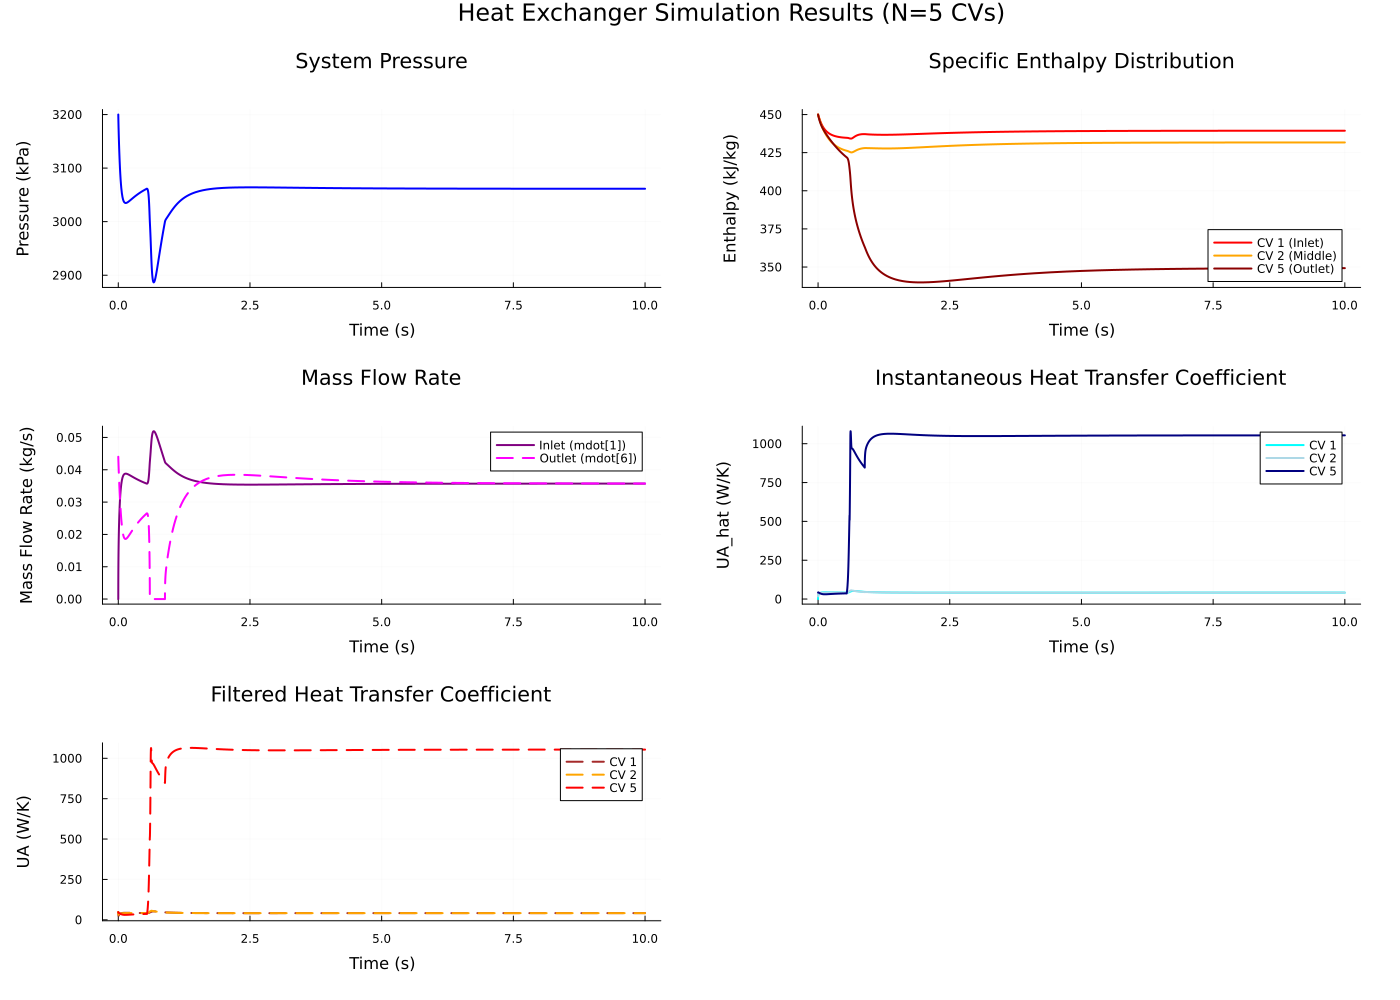

In [28]:
function plot_details_complete(sys, sol, N)
    """
    3 * 2 Plot tools
    """
    @unpack P, h, UA_elem_hat, UA_elem, mdot = sys
    
    # Index
    inlet_idx = 1
    mid_idx = div(N, 2)
    outlet_idx = N
    
    # (1,1) P [kPa]
    p1 = plot(sol.t, sol[P] ./ 1e3, 
              title="System Pressure", xlabel="Time (s)", ylabel="Pressure (kPa)",
              color=:blue, lw=2, legend=false,
              grid=true, gridwidth=1, gridcolor=:lightgray)
    
    # (1,2) h [kJ/kg]
    p2 = plot(sol.t, sol[h[inlet_idx]] ./ 1e3, 
              title="Specific Enthalpy Distribution", xlabel="Time (s)", ylabel="Enthalpy (kJ/kg)",
              label="CV $inlet_idx (Inlet)", color=:red, lw=2)
    plot!(p2, sol.t, sol[h[mid_idx]] ./ 1e3, 
          label="CV $mid_idx (Middle)", color=:orange, lw=2)
    plot!(p2, sol.t, sol[h[outlet_idx]] ./ 1e3, 
          label="CV $outlet_idx (Outlet)", color=:darkred, lw=2)
    plot!(p2, grid=true, gridwidth=1, gridcolor=:lightgray)
    
    # (2,1) density [kg/m³]
    #=
    p3 = plot(sol.t, R410a_ρ(sol[P], sol[h[inlet_idx]]), 
              title="Density Distribution", xlabel="Time (s)", ylabel="Density (kg/m³)",
              label="CV $inlet_idx (Inlet)", color=:green, lw=2)
    plot!(p3, sol.t, R410a_ρ(sol[P], sol[h[mid_idx]]), 
          label="CV $mid_idx (Middle)", color=:lightgreen, lw=2)
    plot!(p3, sol.t, R410a_ρ(sol[P], sol[h[outlet_idx]]), 
          label="CV $outlet_idx (Outlet)", color=:darkgreen, lw=2)
    plot!(p3, grid=true, gridwidth=1, gridcolor=:lightgray)
    =#
    # (2,2) m_flow [kg/s]
    p4 = plot(sol.t, sol[mdot[1]], 
              title="Mass Flow Rate", xlabel="Time (s)", ylabel="Mass Flow Rate (kg/s)",
              label="Inlet (mdot[1])", color=:purple, lw=2)
    plot!(p4, sol.t, sol[mdot[N+1]], 
          label="Outlet (mdot[$(N+1)])", color=:magenta, lw=2, ls=:dash)
    plot!(p4, grid=true, gridwidth=1, gridcolor=:lightgray)
    
    # (3,1) UA_elem_hat [W/K]
    p5 = plot(sol.t, sol[UA_elem_hat[inlet_idx]], 
              title="Instantaneous Heat Transfer Coefficient", xlabel="Time (s)", ylabel="UA_hat (W/K)",
              label="CV $inlet_idx", color=:cyan, lw=2)
    plot!(p5, sol.t, sol[UA_elem_hat[mid_idx]], 
          label="CV $mid_idx", color=:lightblue, lw=2)
    plot!(p5, sol.t, sol[UA_elem_hat[outlet_idx]], 
          label="CV $outlet_idx", color=:navy, lw=2)
    plot!(p5, grid=true, gridwidth=1, gridcolor=:lightgray)
    
    # (3,2) UA_elem [W/K] - Filtered
    p6 = plot(sol.t, sol[UA_elem[inlet_idx]], 
              title="Filtered Heat Transfer Coefficient", xlabel="Time (s)", ylabel="UA (W/K)",
              label="CV $inlet_idx", color=:brown, lw=2, ls=:dash)
    plot!(p6, sol.t, sol[UA_elem[mid_idx]], 
          label="CV $mid_idx", color=:orange, lw=2, ls=:dash)
    plot!(p6, sol.t, sol[UA_elem[outlet_idx]], 
          label="CV $outlet_idx", color=:red, lw=2, ls=:dash)
    plot!(p6, grid=true, gridwidth=1, gridcolor=:lightgray)
    
    
    final_plot = plot(p1, p2, p4, p5, p6, 
                     layout=(3,2), 
                     size=(1400, 1000),
                     plot_title="Heat Exchanger Simulation Results (N=$N CVs)",
                     margin=8Plots.mm)
    
    return final_plot
end

detailed_plot_complete = plot_details_complete(sys, sol, N)

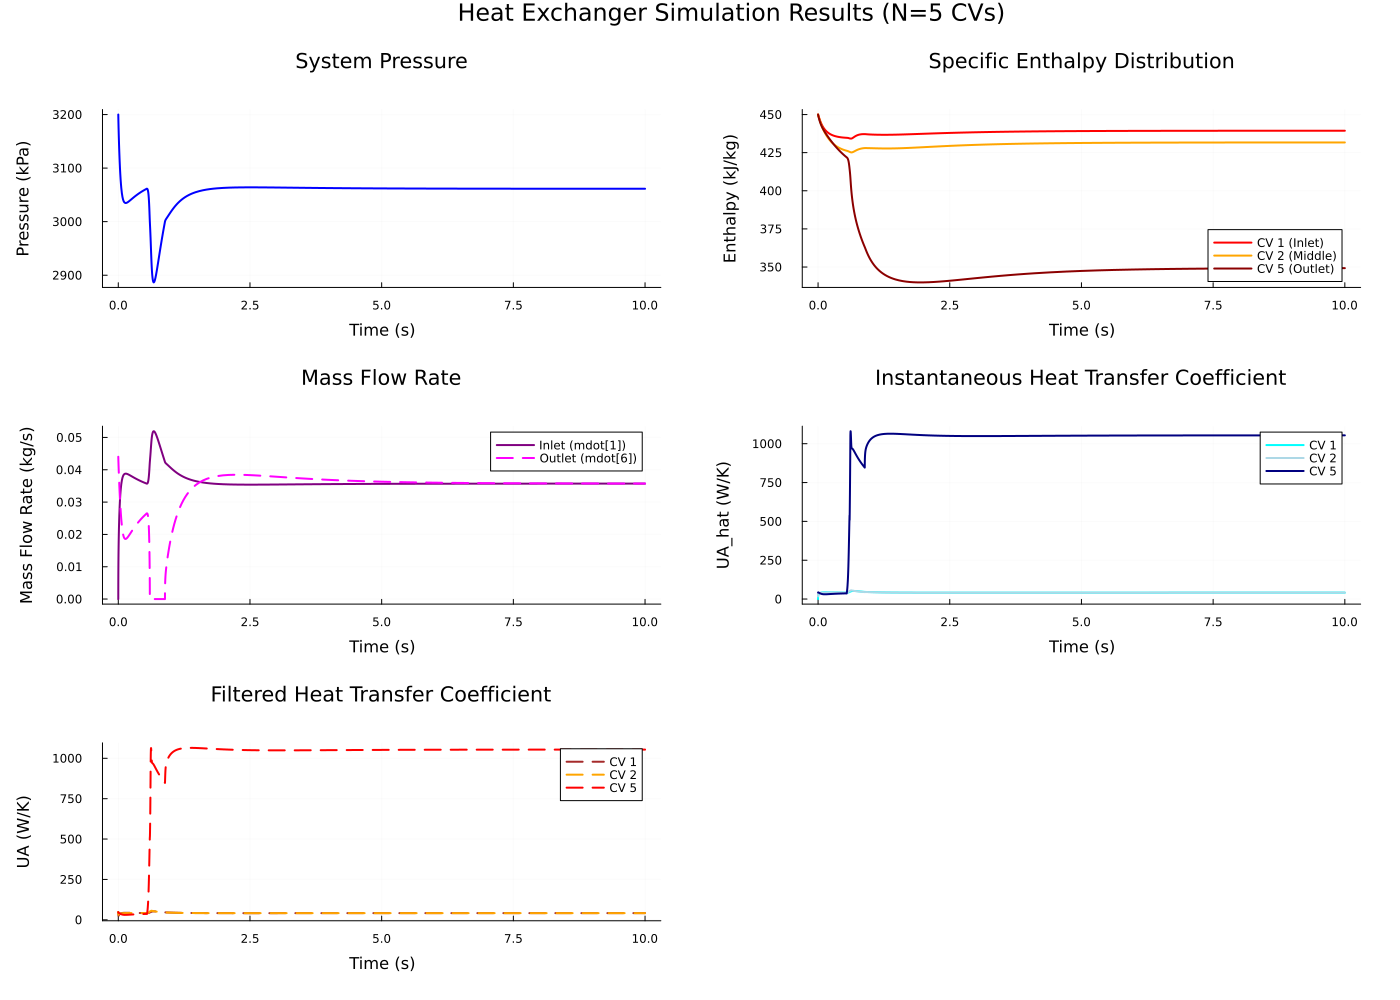

완성된 그래프 저장 완료: HX_simulation_complete_N20.png


In [29]:
# Graph generation
try
    display(detailed_plot_complete)
    savefig(detailed_plot_complete, "HX_simulation_complete_N20.png")
    println("완성된 그래프 저장 완료: HX_simulation_complete_N20.png")
catch e
    println("그래프 표시/저장 오류: ", e)
end